# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [187]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [188]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [189]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [190]:
dataset

,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3,5.0,1.0,0.0,0.0,2.0,0,NaN,NaN
1,201501BS70002,1,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3,9.0,9.0,0.0,0.0,2.0,0,1.0,3.0
2,201501BS70004,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3,1.0,3.0,0.0,0.0,2.0,0,1.0,6.0
3,201501BS70005,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3,5.0,1.0,0.0,0.0,2.0,0,1.0,2.0
4,201501BS70008,1,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363238,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3,0.0,0.0,2.0,0.0,0.0,9,1.0,NaN
363239,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,5.0,3,0.0,0.0,0.0,0.0,0.0,9,1.0,2.0
363240,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,4.0,3,0.0,0.0,0.0,0.0,0.0,9,2.0,5.0
363241,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,6.0,3,0.0,0.0,0.0,0.0,0.0,9,3.0,NaN


In [191]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [192]:
def remove_nans(df):
    '''
    This function removes rows with NaN values.
    '''
    # Drop rows with any NaN value
    df_dropped = df.dropna()

    return df_dropped


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical 
    if it has <= n unique values
    '''
    for col in df.columns:
        
        if col not in ignore:
            
           unique_values = df[col].nunique()
           
           if unique_values <= n:
                df[col] = df[col].astype('category')

        else: 
            pass
    
    return df



def remove_columns_by_n(df, n=10, condition=np.number, direction='less', ignore=[target_column]):
    '''
    Remove columns with more or less than n unique values.
    Usually it makes sense to apply this function to columns with categorical values.
    With the default values, we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''

    # Iterate over each column in the DataFrame
    for col in df.columns:
        
        # Calculate number of unique values in current column
        unique_values = df[col].nunique()
        cond_ind = False
        
        if condition == np.number:
            try: 
                cond_ind = np.issubdtype(df[col].dtype, condition)
            except:
                pass
            
        elif condition == "category":
            cond_ind = pd.api.types.is_categorical_dtype(df[col])
            

        # Check if column should be ignored or is equal to target_column
        if col not in ignore and cond_ind:

            # Check direction parameter and compare unique value count with n
            if direction == 'less' and unique_values < n:
                df.drop(col, axis=1, inplace=True)
            elif direction == 'more' and unique_values > n:
                df.drop(col, axis=1, inplace=True)
                 
            else:
            # If the column is in the ignore list, do nothing
                pass
        
    return df

In [193]:
cond_ind = False
condition = np.number
col = "Vehicle_Reference_df_res"

if condition == np.number:
    try:    
        cond_ind = np.issubdtype(df[col].dtype, condition)
    except:
        pass
            
elif condition == "category":
    cond_ind = pd.api.types.is_categorical_dtype(df[col])
    
print(cond_ind)

False


In [194]:
df = numerical_to_categorical(df, n=2, ignore = [target_column])
df

#df["Vehicle_Reference_df_res"].dtype

,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),...,2nd_Road_Number,Urban_or_Rural_Area,Casualty_Reference,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Pedestrian_Location,Pedestrian_Movement,Casualty_Type,Casualty_IMD_Decile
2,9.0,9.0,0.0,0.0,0.0,1.0,1.0,30.0,6.0,1686.0,...,0.0,1.0,1,2.0,33.0,6.0,1.0,3.0,0,6.0
6,3.0,18.0,0.0,0.0,0.0,1.0,1.0,37.0,7.0,124.0,...,0.0,1.0,1,1.0,37.0,7.0,0.0,0.0,3,5.0
7,19.0,6.0,0.0,0.0,0.0,1.0,1.0,44.0,7.0,2402.0,...,0.0,1.0,1,1.0,37.0,7.0,0.0,0.0,3,5.0
8,9.0,9.0,0.0,0.0,0.0,1.0,1.0,37.0,7.0,1461.0,...,3218.0,1.0,1,1.0,37.0,7.0,0.0,0.0,1,8.0
12,9.0,13.0,0.0,0.0,0.0,1.0,2.0,39.0,7.0,1248.0,...,0.0,1.0,1,1.0,61.0,9.0,0.0,0.0,5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328127,9.0,5.0,0.0,0.0,0.0,1.0,2.0,75.0,10.0,996.0,...,0.0,1.0,2,2.0,43.0,7.0,0.0,0.0,9,6.0
328128,9.0,18.0,0.0,0.0,0.0,1.0,1.0,18.0,4.0,1796.0,...,0.0,1.0,1,1.0,18.0,4.0,0.0,0.0,9,10.0
328129,9.0,18.0,0.0,0.0,0.0,1.0,1.0,18.0,4.0,1796.0,...,0.0,1.0,2,2.0,43.0,7.0,0.0,0.0,9,6.0
328130,9.0,3.0,0.0,0.0,0.0,1.0,2.0,43.0,7.0,1590.0,...,0.0,1.0,1,1.0,18.0,4.0,0.0,0.0,9,10.0


In [195]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more', 
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

C:\Users\Work\AppData\Local\Temp\ipykernel_15032\445265028.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
C:\Users\Work\AppData\Local\Temp\ipykernel_15032\445265028.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
C:\Users\Work\AppData\Local\Temp\ipykernel_15032\445265028.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [186]:
print(df["Urban_or_Rural_Area"].dtype)
print(df["Vehicle_Manoeuvre"].dtype)

category
float64


In [198]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

# Split DataFrame into features and target variable
X = df.drop(columns=[target_column])
Y = df[target_column]

# Perform train-test split
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify = Y)

In [201]:
df.groupby("Sex_of_Driver").size()
# not distributed equally

Sex_of_Driver
1.0    63072
2.0    33101
3.0      153
dtype: int64

In [202]:
print(dataset.shape)
print(df.shape)

(363243, 67)
(96326, 29)


In [204]:
print(df["Sex_of_Driver"].nunique)

<bound method IndexOpsMixin.nunique of 2         1.0
6         1.0
7         1.0
8         1.0
12        2.0
         ... 
328127    2.0
328128    1.0
328129    1.0
328130    2.0
328131    2.0
Name: Sex_of_Driver, Length: 96326, dtype: category
Categories (3, object): ['1.0', '2.0', '3.0']>


**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
    - stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.
    - if not you randomly split the data into a training and a test set
    - here we did split the dataset in a stratified manner.
    - stratified sampling ensures that the target's distirbution is maintained in both sets. 
    - This is particular useful when dealing with imbalanced datasets, where the classes are not represented equally. 
    - Here target's distribution is not well-balanced 
    - Class-dependent patterns: Stratified splitting ensures that the patterns and characteristics of both male and female drivers are well-represented in both the training and test sets. This is         
      particularly important when using tree-based methods, as they can capture and exploit class-specific patterns. By stratifying the split, the model will have exposure to an equal proportion of samples from each class, enabling it to learn class-specific patterns effectively.
    
* How did the dataset dimensions change after preprocessing?
    - They changed from (363243, 67) to (96326, 29)
    
* How many unique values are in the response variable? 
- 3 genders

## Task 1: Create a GradientBoostingClassifier

Gradient Boosting: Imagine you have a bunch of weak learners, such as decision trees, that individually are not very good at making accurate predictions. However, you want to combine them in a way that produces a powerful predictive model. This is where gradient boosting comes into play.

Gradient boosting is an ensemble learning method that combines multiple weak learners (in this case, decision trees) to create a strong predictive model. The idea behind gradient boosting is to iteratively train these weak learners in a sequence, with each subsequent learner trying to correct the mistakes made by the previous ones.

In [205]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set

# Define the GradientBoostingClassifier
model = GradientBoostingClassifier()

# Train the model on the train set
model.fit(train_X, train_y)

# Predict on the test set
predictions = model.predict(test_X)


In [208]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics

# Calculate accuracy
accuracy = accuracy_score(test_y, predictions)
    # Accuracy measures the overall correctness of the predictions made by the model.
    # It is calculated as the ratio of the correctly predicted samples to the total number of samples.

# Calculate precision
precision = precision_score(test_y, predictions, average = "weighted") 
    # Precision measures the ability of the model to correctly identify positive samples (true positives) out of the total samples predicted as positive (true positives + false positives).
    # Precision is calculated as the ratio of true positives to the sum of true positives and false positives.

# Calculate recall (Sensitivity)
recall = recall_score(test_y, predictions, average = "weighted")
    # Recall measures the ability of the model to correctly identify positive samples (true positives) out of the total actual positive samples (true positives + false negatives).
    # It focuses on the completeness of positive predictions.

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Why weighted?
# Calculates metrics for each class independently and then takes the weighted average.
# The weight is based on the support (number of samples) of each class.
# Use this setting when you want to give more importance to classes with larger support, providing a balanced assessment even in the presence of imbalanced class distribution.

Accuracy: 0.771981729471608
Precision: 0.7661310361031585
Recall: 0.771981729471608


In [211]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    for num_trees in trees_amount:
        print(f"Number of Trees: {num_trees}")
        classifier = GradientBoostingClassifier(n_estimators=num_trees)
        classifier.fit(train_X, train_y)
        predictions = classifier.predict(test_X)
        
        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average = "weighted")
        recall = recall_score(test_y, predictions, average = "weighted")
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print()

In [212]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

Number of Trees: 1


c:\Users\Work\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6548
Precision: 0.4296
Recall: 0.6548

Number of Trees: 20
Accuracy: 0.7539
Precision: 0.7468
Recall: 0.7539

Number of Trees: 50
Accuracy: 0.7649
Precision: 0.7583
Recall: 0.7649

Number of Trees: 100
Accuracy: 0.7720
Precision: 0.7661
Recall: 0.7720



In [214]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates=[0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    for lr in learning_rates:
        print(f"Learning Rate: {lr}")
        classifier = GradientBoostingClassifier(learning_rate=lr, n_estimators=trees_amount)
        classifier.fit(train_X, train_y)
        predictions = classifier.predict(test_X)
        
        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print()

In [215]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning Rate: 0.1
Accuracy: 0.7720
Precision (Weighted): 0.7661
Recall (Weighted): 0.7720

Learning Rate: 0.2
Accuracy: 0.7768
Precision (Weighted): 0.7719
Recall (Weighted): 0.7768

Learning Rate: 0.3
Accuracy: 0.7774
Precision (Weighted): 0.7716
Recall (Weighted): 0.7774

Learning Rate: 0.4
Accuracy: 0.7741
Precision (Weighted): 0.7690
Recall (Weighted): 0.7741

Learning Rate: 0.5
Accuracy: 0.7773
Precision (Weighted): 0.7726
Recall (Weighted): 0.7773



In [216]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1, 2, 3, 5], trees_amount=50):
    for depth in depths:
        print(f"Max Depth: {depth}")
        classifier = GradientBoostingClassifier(max_depth=depth, n_estimators=trees_amount)
        classifier.fit(train_X, train_y)
        predictions = classifier.predict(test_X)
        
        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print()
        
# In gradient boosting, the depth refers to the maximum depth of each individual decision tree in the ensemble. It is a hyperparameter that controls the complexity and flexibility of the model.
# The depth of a decision tree refers to the maximum number of levels it can have from the root node to the leaf nodes. The depth determines the complexity of the tree and how deeply it can capture interactions and patterns in the data. A deeper tree can potentially learn more complex relationships but is also more prone to overfitting if the dataset is small or noisy.
# By setting the maximum depth of the decision trees in gradient boosting, you control the level of complexity and generalization ability of the ensemble model. A smaller depth may result in simpler trees and a more constrained model, while a larger depth can lead to more complex trees and potentially higher model capacity.


In [217]:
max_depth_exploration(train_X, train_y, test_X, test_y)

Max Depth: 1


c:\Users\Work\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7459
Precision (Weighted): 0.7370
Recall (Weighted): 0.7459

Max Depth: 2


c:\Users\Work\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7474
Precision (Weighted): 0.7386
Recall (Weighted): 0.7474

Max Depth: 3
Accuracy: 0.7649
Precision (Weighted): 0.7583
Recall (Weighted): 0.7649

Max Depth: 5
Accuracy: 0.7788
Precision (Weighted): 0.7743
Recall (Weighted): 0.7788



**TODO :**   

* How does the max_depth parameter influence the results? 

The higher the depth, the better the performance. Computation takes longer.

* How does the learning rate influence the results?

The higher the learning rate, the better the performance. Computation takes longer.

* How does the number of trees in the ensemble influence the results?

The higher the number of trees, the better the performance. However, the increase is declining for each additional tree. Computation takes longer.

* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

todo

In [228]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot


def plot_explained_variance(clf, X):
    # Get the feature importances from the classifier
    feature_importance = clf.feature_importances_
    
    # Sort the feature importances in descending order and get the corresponding indices
    sorted_indices = feature_importance.argsort()
    
    # Sort the feature importances and feature names based on the sorted indices
    sorted_importance = feature_importance[sorted_indices]
    feature_names = X.columns[sorted_indices]
    
    # Create a horizontal bar plot to visualize the relative importance of features
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importance)), sorted_importance)
    
    # Set the y-axis labels as the sorted feature names in reverse order to plot the most important features on top
    plt.yticks(range(len(sorted_importance)), feature_names)
    
    # Add axis labels and a title to the plot
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Relative Importance of Features")
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()
    
    # clf: The clf argument is the trained classifier model (e.g., a GradientBoostingClassifier) that has been fitted on the training data. It should have the feature_importances_ attribute, which provides the relative importance of each feature.

    # X: The X argument represents the feature data used for training the classifier. It can be a pandas DataFrame, a NumPy array, or any other array-like object where each column corresponds to a feature. The X data should have the same number of columns and the same column order as the data used to train the classifier.

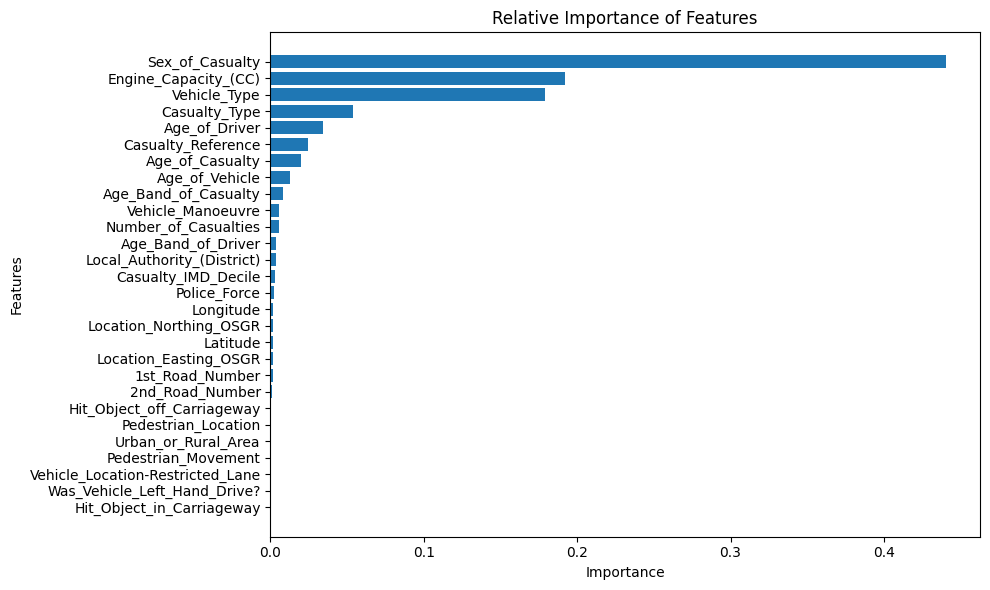

In [229]:
## TODO : display the plot
plot_explained_variance(model, train_X)

**TODO :** Interpret the plot.

Most important: Sex of Causalty. In general it seems that characteristics of causalty, the driver and the cars are important.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 



## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises.*


In [ ]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    

In [ ]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    # Todo


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # Todo

In [ ]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO

In [ ]:
# TODO write a plot function 
## Hint - you can use yours from practical 2 or 3 


### Convert a pandas dataframe to a PyTorch dataset

In [ ]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        ''' 
        self.x = 
        self.y = 
        self.mean = 
        self.std = 
        self.normalise = 
    
    def __len__(self):
        # TODO: return the length of the whole dataset

    
    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        

In [ ]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer


In [ ]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!


## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256


## Logistic regression

In [ ]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # TODO run the data through the layer
        
        return outputs

In [ ]:
## TODO define model, loss and optimisers
## don't forget to move everything for the correct devices
## 
lr=0.001


In [ ]:
## TODO train the network
num_epochs = 30


In [ ]:
## todo - plot losses and accuracies
plot('Epoch vs. Loss', 'Loss', train_losses_lr, val_losses_lr)

In [ ]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_lr, val_accs_lr)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

In [ ]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            
        )
      

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO

In [ ]:
## TODO : define model, optimiser, cross entropy loss,
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr=0.001


In [ ]:
## TODO : Train model
num_epochs = 50


In [ ]:
# TODO plot losses
plot('Epoch vs. Loss', 'Loss', train_losses, val_losses)

In [ ]:
# TODO plot accuracies
plot('Epoch vs. Accuracy', 'Accuracy', train_accs, val_accs)

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/